## Homework 1

**Programming Exercise 2.5**

Design and conduct an experiment to demonstrate the diffculties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the q⇤(a) start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the q⇤(a) on each step). Prepare plots like Figure 2.2 for an 
action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, a=0.1. Use e=0.1 and longer runs, say of 10,000 steps.

#### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Classes

### Epsilon Greedy w/ Sample Average

In [ ]:
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of times each arm is pulled
        self.values = np.zeros(n_arms)  # Estimated values of each arm

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            best_arms = np.where(self.values == np.max(self.values))[0]
            return np.random.choice(best_arms)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = value + (1/n) * (reward - value)

### Epsilon Greedy w/ Constant Step Size

In [ ]:
class EpsilonGreedyStepSize:
    def __init__(self, n_arms, epsilon, alpha):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.alpha = alpha
        self.counts = np.zeros(n_arms)  # Number of times each arm is pulled
        self.values = np.zeros(n_arms)  # Estimated values of each arm

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            best_arms = np.where(self.values == np.max(self.values))[0]
            return np.random.choice(best_arms)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = value + self.alpha * (reward - value)

### 10-Armed Testbed (Modified w/ Random Walks)

In [ ]:
class TenArmedTestbed:
    def __init__(self, k=10):
        self.k = k
        self.q_star = np.zeros(k)  # Start all action values at zero

    def get_reward(self, action):
        return np.random.normal(self.q_star[action], 1)

    def optimal_action(self):
        return np.argmax(self.q_star)

    def update_q_star(self):
        self.q_star += np.random.normal(0, 0.01, self.k)  # Random walk

To ensure correctness of TenArmedTestbed, plot the reward distribtuion for 5 different actions over 1000 runs.

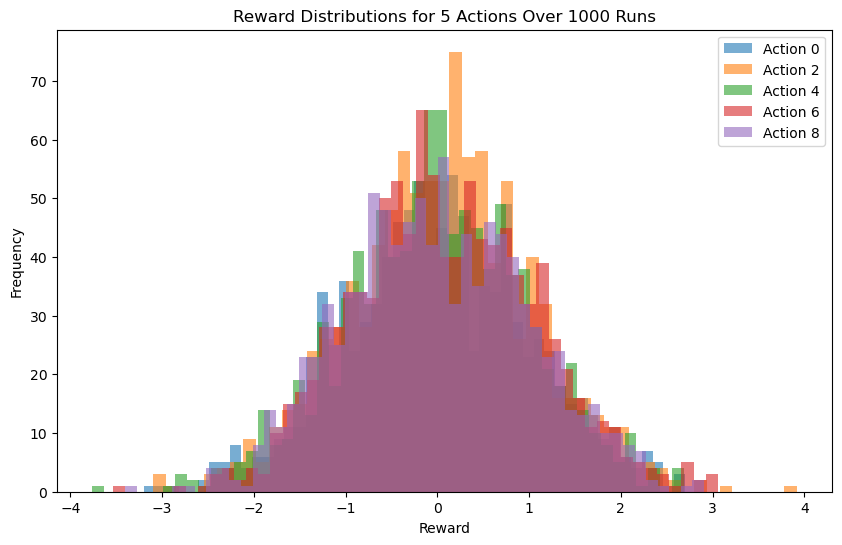

In [50]:
testbed = TenArmedTestbed()
actions_to_plot = [0, 2, 4, 6, 8]
rewards = {action: [testbed.get_reward(action) for _ in range(
    1000)] for action in actions_to_plot}

plt.figure(figsize=(10, 6))
for action, reward_list in rewards.items():
    plt.hist(reward_list, bins=50, alpha=0.6, label=f'Action {action}')

plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()
plt.title("Reward Distributions for 5 Actions Over 1000 Runs")
plt.show()

## Experiments

Code to run an experiment given an agent, a testbed, and the number of steps.

In [ ]:
def experiment(testbed, agent, n_steps):

    rewards = []
    optimal_action_counts = []

    for _ in range(n_steps):
        action = agent.select_arm()
        reward = testbed.get_reward(action)
        agent.update(action, reward)
        rewards.append(reward)
        optimal_action_counts.append(
            1 if action == testbed.optimal_action() else 0)
        testbed.update_q_star()

    return rewards, optimal_action_counts

### Epsilon Greedy w/ Sample Averages vs Epsilon Greedy w/ Constant Step Size

In [ ]:
steps = 10000
runs = 2000
epsilons = 0.1
alpha = 0.1

average_rewards = np.zeros((2, steps))
optimal_action_perc = np.zeros((2, steps))

for _ in range(runs):
    testbed = TenArmedTestbed() 

    for agent_id, AgentClass in enumerate([EpsilonGreedyStepSize, EpsilonGreedy]):
        agent = AgentClass(testbed.k, epsilons, alpha) if agent_id == 0 else AgentClass(
            testbed.k, epsilons)
        rewards, optimal_action_counts = experiment(testbed, agent, steps)

        average_rewards[agent_id] += rewards
        optimal_action_perc[agent_id] += optimal_action_counts

average_rewards /= runs
optimal_action_perc = (optimal_action_perc / runs) * 100

In [48]:
np.save("average_rewards_initial.npy", average_rewards)
np.save("optimal_action_perc_initial.npy", optimal_action_perc)

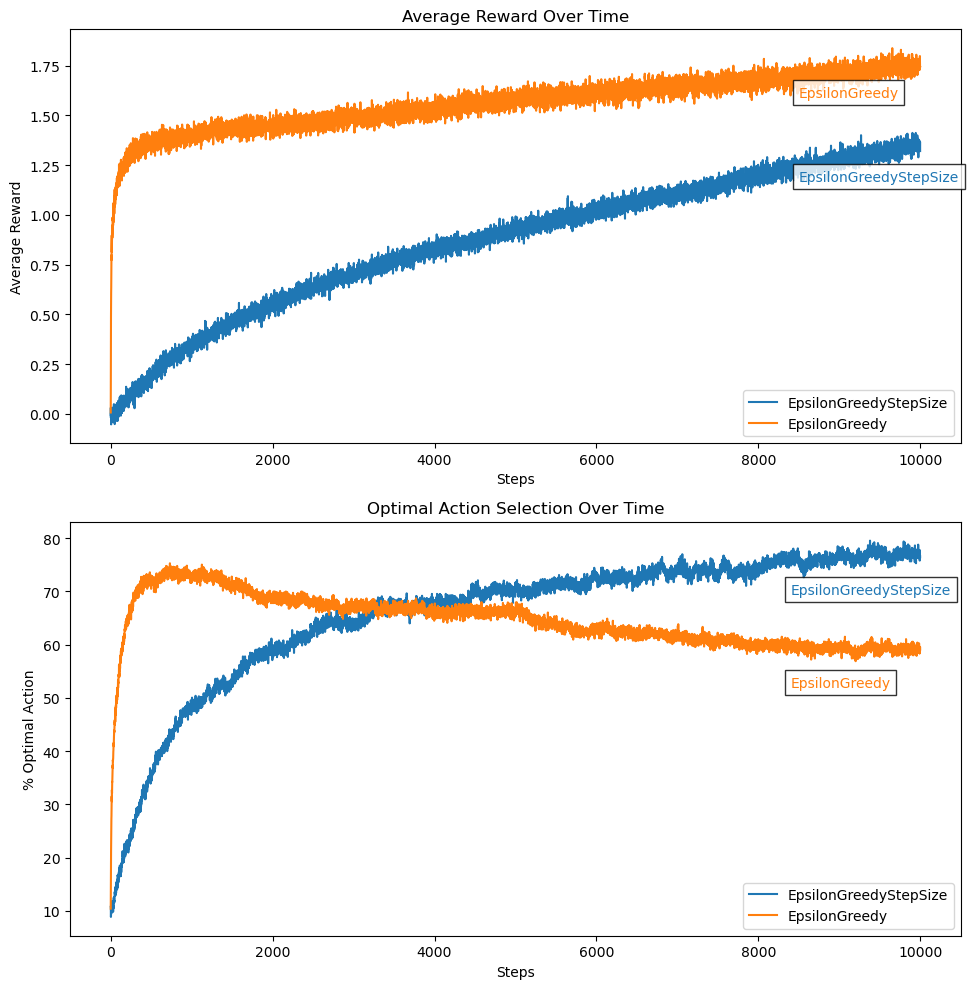

In [49]:
x = np.arange(steps)
colors = ["#1f77b4", "#ff7f0e"]
labels = ["EpsilonGreedyStepSize", "EpsilonGreedy"]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Average Rewards
for i in range(n_experiments):
    axs[0].plot(x, average_rewards[i], label=labels[i], color=colors[i])
    axs[0].text(
        steps - 1500, average_rewards[i][-1] - 0.15, labels[i],
        color=colors[i], fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8,
                  edgecolor='black')  # Add white background
    )

axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Average Reward")
axs[0].set_title("Average Reward Over Time")
axs[0].legend(loc="lower right")  # Add legend

# Plot % Optimal Actions
for i in range(n_experiments):
    axs[1].plot(x, optimal_action_perc[i], label=labels[i], color=colors[i])
    axs[1].text(
        steps - 1600, optimal_action_perc[i][-1] - 7, labels[i],
        color=colors[i], fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8,
                  edgecolor='black')  # Add white background
    )

axs[1].set_xlabel("Steps")
axs[1].set_ylabel("% Optimal Action")
axs[1].set_title("Optimal Action Selection Over Time")
axs[1].legend(loc="lower right")  # Add legend

plt.tight_layout()
plt.show()

### Different values of epsilon with EpsilonGreedyStepSize

In [76]:
steps = 10000
runs = 2000
epsilons = [0.1, 0.01, 0.0]
alpha = 0.1

average_rewards = np.zeros((len(epsilons), steps))
optimal_action_perc = np.zeros((len(epsilons), steps))

for _ in range(runs):
    testbed = TenArmedTestbed()

    for i, epsilon in enumerate(epsilons):
        agent = EpsilonGreedyStepSize(testbed.k, epsilon, alpha)
        rewards, optimal_action_counts = experiment(testbed, agent, steps)

        average_rewards[i] += rewards
        optimal_action_perc[i] += optimal_action_counts

average_rewards /= runs
optimal_action_perc = (optimal_action_perc / runs) * 100

In [81]:
np.save("average_rewards_epsilon.npy", average_rewards)
np.save("optimal_action_perc_epsilon.npy", optimal_action_perc)

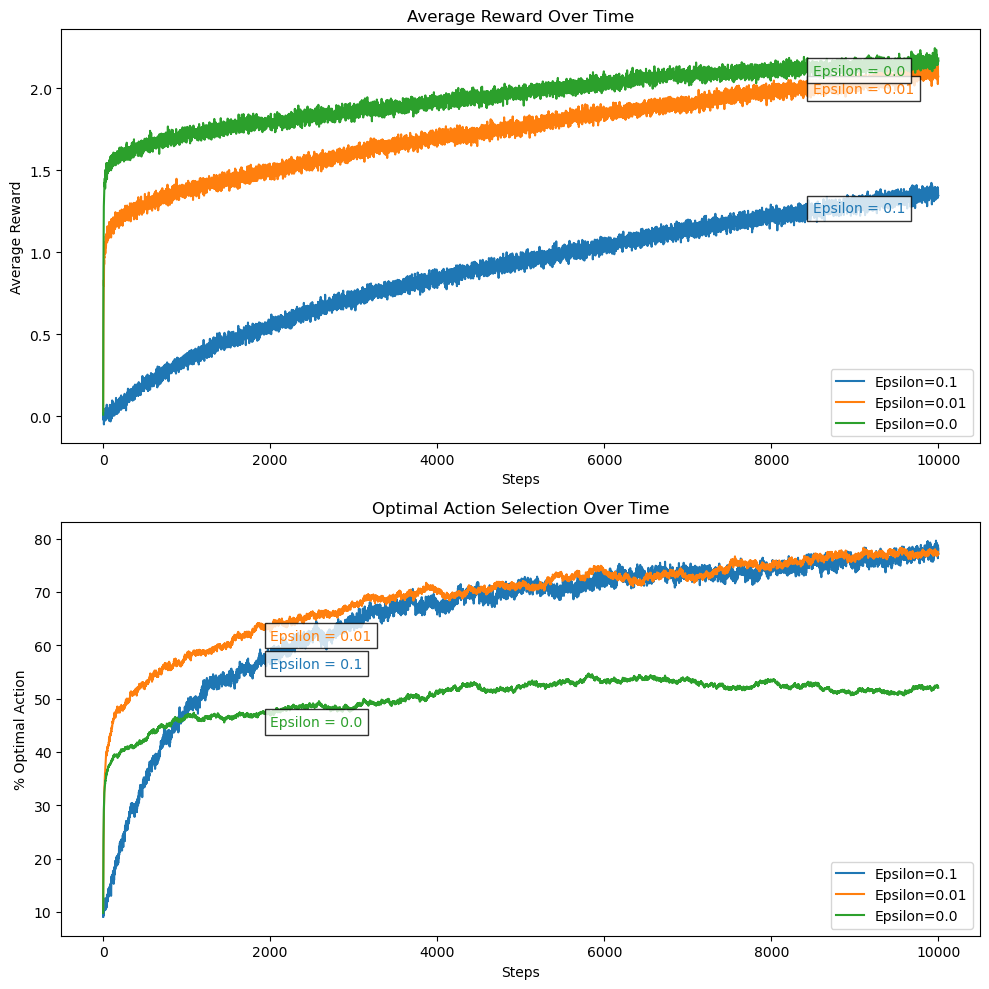

In [97]:

x = np.arange(steps)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
labels = [f"Epsilon = {eps}" for eps in epsilons]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for i, epsilon in enumerate(epsilons):
    axs[0].plot(x, average_rewards[i], label=f"Epsilon={epsilon}")
    axs[0].text(
        steps - 1500, average_rewards[i][-1] - 0.1, labels[i],
        color=colors[i], fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Average Reward")
axs[0].set_title("Average Reward Over Time")
axs[0].legend(loc="lower right")

for i, epsilon in enumerate(epsilons):
    axs[1].plot(x, optimal_action_perc[i], label=f"Epsilon={epsilon}")
    axs[1].text(
        steps - 8000, optimal_action_perc[i][-8000] - 2, labels[i],
        color=colors[i], fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

axs[1].set_xlabel("Steps")
axs[1].set_ylabel("% Optimal Action")
axs[1].set_title("Optimal Action Selection Over Time")
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [145]:
steps = 10000
runs = 2000
epsilons = 0.1
alpha = [0.1, 0.25, 0.5]

average_rewards = np.zeros((len(alpha) + 1, steps))
optimal_action_perc = np.zeros((len(alpha) + 1, steps))

for _ in range(runs):
    testbed = TenArmedTestbed()

    for i, a in enumerate(alpha):
        agent = EpsilonGreedyStepSize(testbed.k, epsilons, a)
        rewards, optimal_action_counts = experiment(testbed, agent, steps)

        average_rewards[i] += rewards
        optimal_action_perc[i] += optimal_action_counts

    agent = EpsilonGreedy(testbed.k, epsilons)
    rewards, optimal_action_counts = experiment(testbed, agent, steps)
    average_rewards[-1] += rewards
    optimal_action_perc[-1] += optimal_action_counts

average_rewards /= runs
optimal_action_perc = (optimal_action_perc / runs) * 100

KeyboardInterrupt: 

In [ ]:
np.save("average_rewards_alpha_initial.npy", average_rewards)
np.save("optimal_action_perc_alpha_inital.npy", optimal_action_perc)

In [150]:
average_rewards = np.load("average_rewards_alpha_initial.npy")
optimal_action_perc = np.load("optimal_action_perc_alpha_inital.npy")

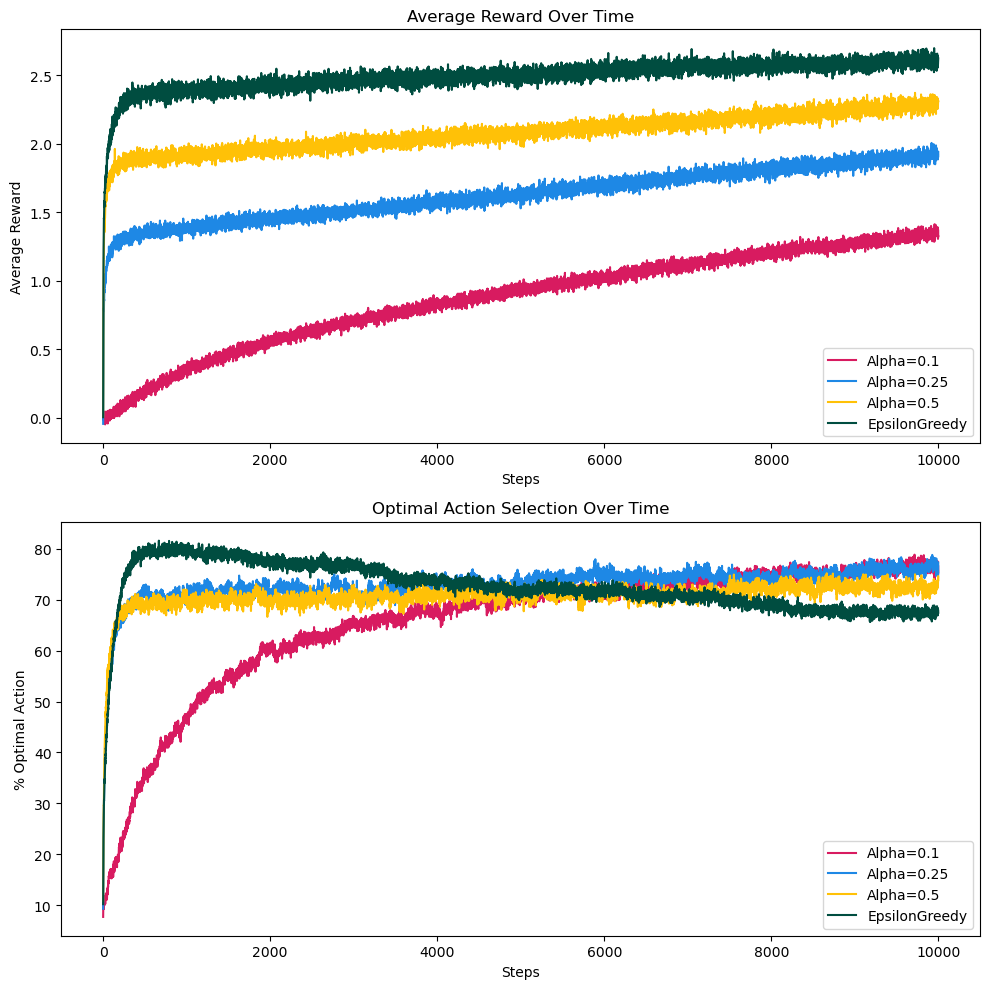

In [151]:
# Plotting
x = np.arange(steps)
colors = ["#D81B60", "#1E88E5", "#FFC107", "#004D40"]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Average Rewards
for i in range(len(alpha)):
    axs[0].plot(x, average_rewards[i],
                label=f"Alpha={alpha[i]}", color=colors[i])

axs[0].plot(x, average_rewards[-1], label="EpsilonGreedy", color=colors[-1])

axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Average Reward")
axs[0].set_title("Average Reward Over Time")
axs[0].legend(loc="lower right")

# Plot % Optimal Actions
for i in range(len(alpha)):
    axs[1].plot(x, optimal_action_perc[i],
                label=f"Alpha={alpha[i]}", color=colors[i])

axs[1].plot(x, optimal_action_perc[-1],
            label="EpsilonGreedy", color=colors[-1])

axs[1].set_xlabel("Steps")
axs[1].set_ylabel("% Optimal Action")
axs[1].set_title("Optimal Action Selection Over Time")
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

### Additional exploration
* Try a different action selection method: Upper Confidence Bound (UCB)
* Test optimistic initial values with nonstationary rewards
* Try different reward distributions

In [ ]:
class TenArmedTestbedSuddenChange:
    def __init__(self, k=10):
        self.k = k
        self.q_star = np.zeros(k)

    def get_reward(self, action):
        return np.random.normal(self.q_star[action], 1)

    def optimal_action(self):
        return np.argmax(self.q_star)

    def update_q_star(self):
        # Instead of a small random walk, apply occasional large changes
        if np.random.rand() < 0.1:  # 10% chance of a large jump
            self.q_star += np.random.normal(0, 1, self.k)
        else:
            self.q_star += np.random.normal(0, 0.01, self.k)  # Small updates

In [110]:
steps = 10000
runs = 2000
epsilons = 0.1
alpha = 0.1

average_rewards = np.zeros((2, steps))
optimal_action_perc = np.zeros((2, steps))

for _ in range(runs):
    testbed = TenArmedTestbedSuddenChange()

    for agent_id, AgentClass in enumerate([EpsilonGreedyStepSize, EpsilonGreedy]):
        agent = AgentClass(testbed.k, epsilons, alpha) if agent_id == 0 else AgentClass(
            testbed.k, epsilons)
        rewards, optimal_action_counts = experiment(testbed, agent, steps)

        average_rewards[agent_id] += rewards
        optimal_action_perc[agent_id] += optimal_action_counts

average_rewards /= runs
optimal_action_perc = (optimal_action_perc / runs) * 100

KeyboardInterrupt: 

In [ ]:
np.save("average_rewards_diff_testbed.npy", average_rewards)
np.save("optimal_action_perc_diff_testbed.npy", optimal_action_perc)

In [112]:
average_rewards = np.load("average_rewards_diff_testbed.npy")
optimal_action_perc = np.load("optimal_action_perc_diff_testbed.npy")

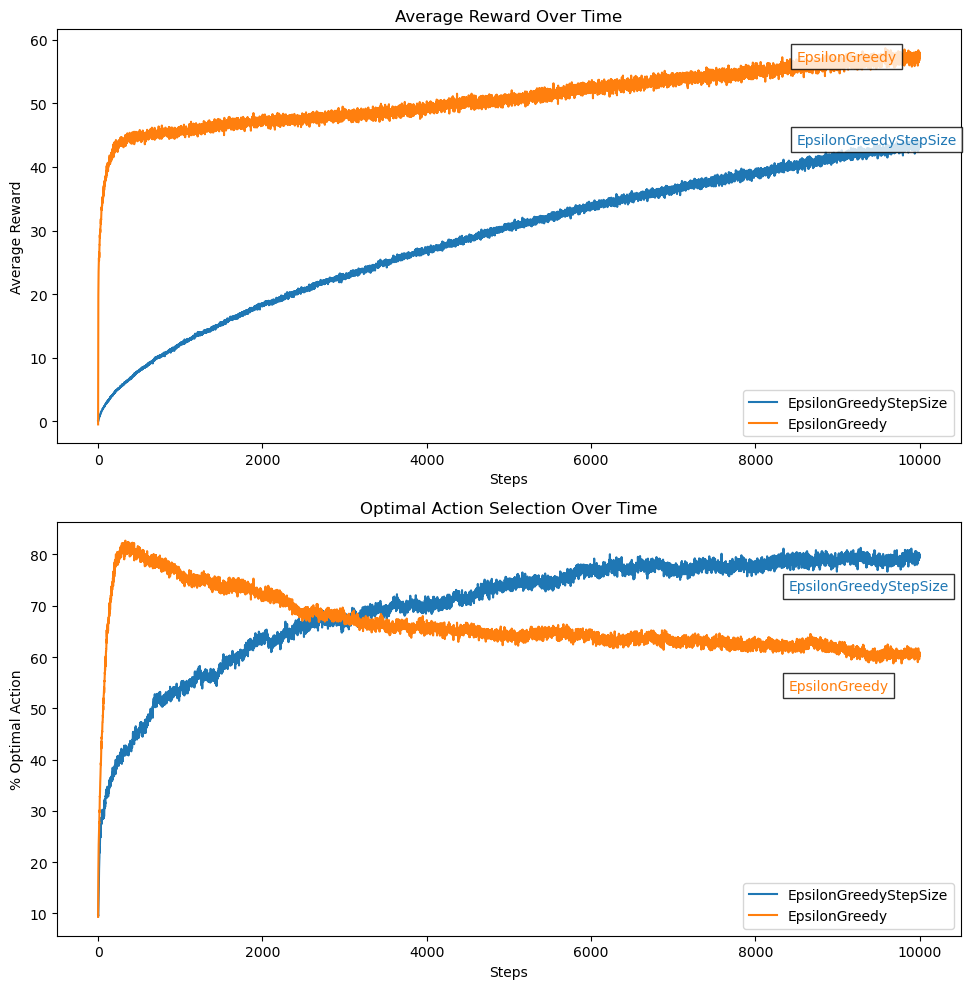

In [113]:
x = np.arange(steps)
colors = ["#1f77b4", "#ff7f0e"]
labels = ["EpsilonGreedyStepSize", "EpsilonGreedy"]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Average Rewards
for i in range(2):
    axs[0].plot(x, average_rewards[i], label=labels[i], color=colors[i])
    axs[0].text(
        steps - 1500, average_rewards[i][-1] - 0.15, labels[i],
        color=colors[i], fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8,
                  edgecolor='black')  # Add white background
    )

axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Average Reward")
axs[0].set_title("Average Reward Over Time")
axs[0].legend(loc="lower right")  # Add legend

# Plot % Optimal Actions
for i in range(2):
    axs[1].plot(x, optimal_action_perc[i], label=labels[i], color=colors[i])
    axs[1].text(
        steps - 1600, optimal_action_perc[i][-1] - 7, labels[i],
        color=colors[i], fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8,
                  edgecolor='black')  # Add white background
    )

axs[1].set_xlabel("Steps")
axs[1].set_ylabel("% Optimal Action")
axs[1].set_title("Optimal Action Selection Over Time")
axs[1].legend(loc="lower right")  # Add legend

plt.tight_layout()
plt.show()

#### Try different values of alpha

In [131]:
steps = 10000
runs = 2000
epsilons = 0.1
alpha = [0.1, 0.25, 0.5]

average_rewards = np.zeros((len(alpha) + 1, steps))
optimal_action_perc = np.zeros((len(alpha) + 1, steps))

for _ in range(runs):
    testbed = TenArmedTestbedSuddenChange()

    for i, a in enumerate(alpha):
        agent = EpsilonGreedyStepSize(testbed.k, epsilons, a)
        rewards, optimal_action_counts = experiment(testbed, agent, steps)

        average_rewards[i] += rewards
        optimal_action_perc[i] += optimal_action_counts

    agent = EpsilonGreedy(testbed.k, epsilons)
    rewards, optimal_action_counts = experiment(testbed, agent, steps)
    average_rewards[-1] += rewards
    optimal_action_perc[-1] += optimal_action_counts

average_rewards /= runs
optimal_action_perc = (optimal_action_perc / runs) * 100

In [132]:
# Save results
np.save("average_rewards_alpha.npy", average_rewards)
np.save("optimal_action_perc_alpha.npy", optimal_action_perc)

In [142]:
np.load("average_rewards_alpha.npy")
np.load("optimal_action_perc_alpha.npy")

array([[10.8 , 10.05, 10.2 , ..., 79.55, 78.65, 79.7 ],
       [ 9.75, 15.05, 17.5 , ..., 85.85, 86.6 , 86.45],
       [ 9.05, 13.75, 17.2 , ..., 87.7 , 87.45, 87.8 ],
       [ 9.2 , 15.15, 17.8 , ..., 64.5 , 65.3 , 64.75]])

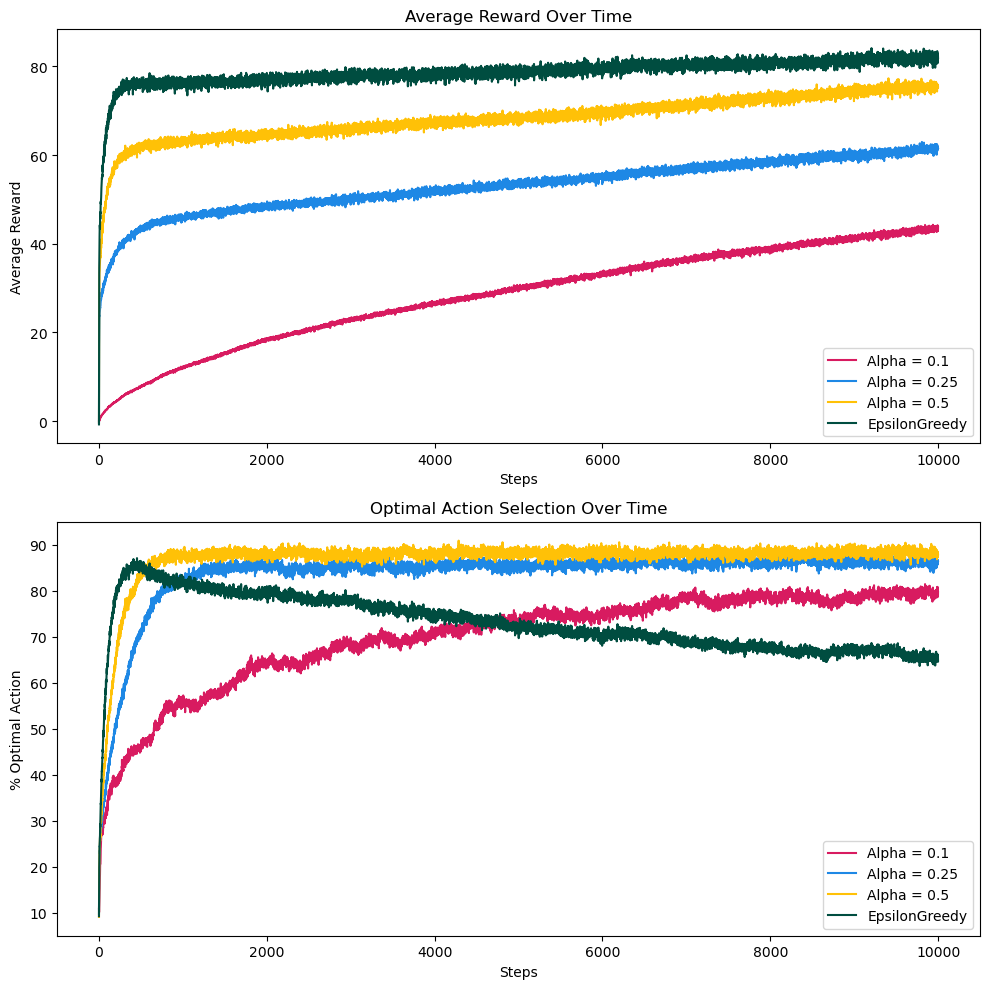

In [143]:
# Plot results
x = np.arange(steps)
colors = ["#D81B60", "#1E88E5", "#FFC107"]
labels = [f"Alpha = {a}" for a in alpha]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for i, a in enumerate(alpha):
    axs[0].plot(x, average_rewards[i], label=labels[i], color=colors[i])

# Plot EpsilonGreedy
axs[0].plot(x, average_rewards[-1], label="EpsilonGreedy", color="#004D40")


axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Average Reward")
axs[0].set_title("Average Reward Over Time")
axs[0].legend(loc="lower right")

for i, a in enumerate(alpha):
    axs[1].plot(x, optimal_action_perc[i], label=labels[i], color=colors[i])

# Plot EpsilonGreedy
axs[1].plot(x, optimal_action_perc[-1], label="EpsilonGreedy", color="#004D40")

axs[1].set_xlabel("Steps")
axs[1].set_ylabel("% Optimal Action")
axs[1].set_title("Optimal Action Selection Over Time")
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()